In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.api import add_constant
from statsmodels.sandbox.regression.gmm import IV2SLS

%store -r perform_dist_high_compare_b3

In [45]:
df = pd.read_csv('perform_dist_high_compare_b3.csv', header=0)
df = df.dropna()
df

,Unnamed: 0,Student,group,abs_perform_diff_best,phase,Q7_Q7_1,Q7_Q7_2,Q8_Q8_1,Q10,user2,similarity
0,0,lemartinp,3,270.84,1,0.0,0.0,4.0,1.0,lemartinp,0.146341
1,1,juligarji,3,167.50,1,4.0,4.0,5.0,3.0,juligarji,0.057325
2,2,nfmorenog,3,225.00,1,0.0,2.0,3.0,1.0,nfmorenog,0.190476
3,3,AFelipeGA,3,291.67,1,4.0,3.0,5.0,2.0,AFelipeGA,0.090909
4,4,mballeng91,3,329.17,1,2.0,6.0,6.0,2.0,mballeng91,0.004854
...,...,...,...,...,...,...,...,...,...,...,...
159,159,NicolasPrr,3,237.50,4,3.0,4.0,3.0,2.0,NicolasPrr,0.009360
160,160,jumcorredorro,3,53.33,4,1.0,1.0,5.0,2.0,jumcorredorro,0.013294
161,161,feartheGru,3,358.33,4,2.0,2.0,5.0,2.0,feartheGru,0.000000
162,162,Danielsv9207,3,358.33,4,1.0,1.0,1.0,3.0,Danielsv9207,0.000000


In [57]:
#Let's confirm that aspiration satisfy the relevance condition for performance distance to the best 
reg_expr = 'abs_perform_diff_best ~ Q10'

# Build and train an OLS model that regresses performance distance to the best on aspiration and verify
# using the F-test that coefficients of aspiration is significant 
olsr_model = smf.ols(formula=reg_expr, data=df)
olsr_model_results = olsr_model.fit()
print(olsr_model_results.summary())

df['ln_similarity'] = np.log(df['similarity'] + 1)

# Build out the exog matrix. Statsmodels requires this matrix to contain all the endogenous and
# exogenous variables, plus the constant.
exog = df[['abs_perform_diff_best']]
exog = add_constant(exog)

# Build out the instruments matrix. Statsmodels requires this matrix to contain not only all the
# instruments but also the variables in exog that will NOT be instrumented
instruments = df[['Q10']]
instruments = add_constant(instruments)

#Build and train the IV2SLS model
iv2sls_model = IV2SLS(endog=df['ln_similarity'], exog=exog, instrument=instruments)
iv2sls_model_results = iv2sls_model.fit()

#Print the training summary
print(iv2sls_model_results.summary())

#Compare the performance of 2SLS with OLS of ln(wage) on performance distance to the best
reg_expr = 'ln_similarity ~ abs_perform_diff_best'
olsr_model = smf.ols(formula=reg_expr, data=df)
olsr_model_results = olsr_model.fit()
print(olsr_model_results.summary())

                              OLS Regression Results                             
Dep. Variable:     abs_perform_diff_best   R-squared:                       0.086
Model:                               OLS   Adj. R-squared:                  0.080
Method:                    Least Squares   F-statistic:                     14.87
Date:                   Sun, 11 Sep 2022   Prob (F-statistic):           0.000167
Time:                           18:26:17   Log-Likelihood:                -913.78
No. Observations:                    160   AIC:                             1832.
Df Residuals:                        158   BIC:                             1838.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    258.9941 

## Comments

![image1](image1.png)

The coefficients of aspiration (Q10) is significant at a p of < 0 as indicated by their p-values which are basically zero. Aspiration (Q10) clearly meet the **relevance condition** for instrumental variables of performance distance. 

We’ll now build a linear model for the similarity to the best equation and using statsmodels, we’ll train the model using the two-stage least square estimator.

We’ll start by building the design matrices. The dependent variable is ln(similarity). 

```
ln_wage = np.log(df['similarity'])
```

Statsmodel’s IV2SLS estimator is defined as follows:

```

statsmodels.sandbox.regression.gmm.IV2SLS(endog, exog, instrument=None)

```
Statsmodels needs the endog, exog and instrument matrices to be constructed in a specific way as follows:

`endog` is an [n x 1] matrix containing the dependent variable. In our example, it is the ln_wage variable.

`exog` is an [n x (k+1)] size matrix that must contain all the endogenous and exogenous variables, plus the constant. In our example, apart from the constant, we do not have any exogenous variables defined in our wage equation. 

`instrument` is a matrix that contains the instrumental variables. Additionally, the Statsmodels’ IV2SLS estimator requires instrument to also contain all variables from the exog matrix that are not being instrumented. In our example, the instrumental variables are meducation and feducation. The variables in exog that are not being instrumented is just the placeholder column for the intercept. 

![image2](image2.png)

## Interpretation of results of the 2SLS model

Since our primary interest is in estimating the effect of performance distance to the best on similarity to the best, we’ll focus our attention on the coefficient estimate of the performance distance to the best. 

We see that the 2SLS model has estimated the coefficient of performance distance to the best as -0.0004 with a standard error of 0.000 and a 95% confidence interval of -0.001 to 4.89e-05. The p-value of 0.084 suggests a significance at (1–0.084)100%=91.6%. Overall, and as expected for a 2SLS model, the model lacks precision.

Note that dependent variable is log(similarity + 1). To calculate the rate of change of similarity to the best for each unit change of performance distance to the best, we must exponentiate the coefficient of education.

1 - 10^(-0.004) = 0.00092 implying that a unit decrease in performance distance to the best is estimated to yield an increase of 0.00917 in similarity to the best, and vice-versa.

## Comparison of the IV estimator with an OLS estimator 

Let’s compare the performance of the 2SLS model with a straight-up OLS model that regresses log(similarity) on performance distance to the best. 

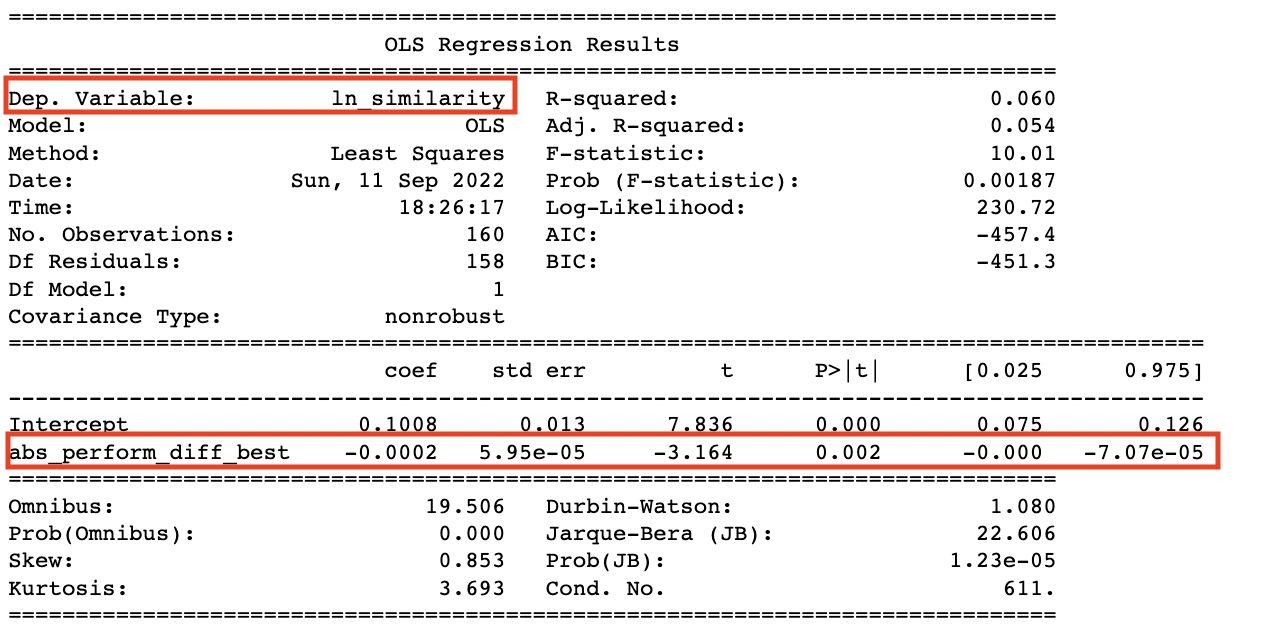

We’ll focus our attention on the estimated value of the coefficient of performance distance to the best. At -0.0002, it is double the estimate reported by the 2SLS model.

1 - 10^(-0.0002)=0.00046, implying a unit decrease in the performance distance to the best is estimated to translate into a 0.00046 increase in similarity to the best (vice versa). 

The higher estimate from OLS is expected due to the suspected endogeniety of performance distance to the best. In practice, depending on the situation we are modeling, we may want to accept the more conservative estimate of -0.0004 reported by the 2SLS model. However, (and against the 2SLS model), the coefficient estimate from the OLS model is highly significant with a p-value that is 0.002. Recollect that the estimate from the 2SLS model was significant at only a 92% confidence level.

The coefficient estimate of education reported by the OLS model has pretty similar standard error which is zero as compared to that from the 2SLS model. 

For comparison, here are the coefficient estimates of education and corresponding 95% CIs from the two models:

With the IV estimator, one trades precision of estimates for the removal of endogeneity and the consequent bias in the estimates.

